# Continuum Normalize

The spectrum from a star or object is not level.  In a simple approximation, the spectrum of a star follows a blackbody curve with emission or absorption lines superimposed.

The object spectrum extracted from the detector will, of course, follow some distribution.  This distribution will be affected by the object's inherent spectrum and also by the instruments.  For example, echelle spectrographs often send less light to the ends of each order.  If a spectrum is extracted from one order, it would follow a general parabolic shape (plus inherent distribution) beacause of the optics of the spectrograph. 

If we wish to compare spectral features across spectra, we often need to continuum normalize the spectrum such that we see spectral features superimposed on a flat line instead of some curve. This flat line is often chosen to be at 1. 

___
The method which will most succesfully continuum normalize a spectrum depends on that spectrum.  Here several methods are presented which can be used to continuum normalize a spectrum.

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np 
import os 
import sys
from os import listdir
import shutil

from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy import units as u

# ----------------- Import the other files of functions
module_path = os.path.abspath(os.path.join('../ASAP'))
if module_path not in sys.path:
    sys.path.append(module_path)

import asap_lib.moog_funcs as mf
import asap_lib.auto_atmosphere as aa
import asap_lib.calc_abunds as calc_abunds
import asap_lib.line_list_utils as llu
import asap_lib.spectra as sa

from scipy.stats import sigmaclip
from astropy.stats import sigma_clip
from scipy.signal import medfilt
from scipy.ndimage import median_filter 

import specutils
import specutils.analysis

# Method: 2-Stage Continuum Normalization

The continuum is first estimated by applying a median filter to the flux.  A sufficienlty large window will remove absorption lines, emission lines, and egregious noise.   
The flux is then divided by the first continuum estimate.  This flattens the spectrum and brings the continuum close to one.  

The continuum position is then adjusted a final time.  A sigma-clipping routine is applied to  remove absorption and emission lines, leaving an estimate of the continuum. The flux is then divided by the mean of the continuum to bring the continuum closer  to 1.

**Read In Data**

In [2]:
# ------- Path to data
path = '../Data/HD122563-ESO/ADP.2019-05-01T09:30:53.676.fits'


# ------- Read in data (spectrum specific)
hdul = fits.open(path)

dataorg = {}        
check = ['TTYPE1', 'TTYPE2', 'TTYPE3', 'TTYPE4', 'TTYPE5', 'TTYPE6']
for item in check:
    if item in hdul[1].header:
        dataorg[hdul[1].header[item]] =  item.strip('TTYPE')

flux = hdul[1].data[0][int(dataorg['FLUX_REDUCED'])-1]

wave = hdul[1].data[0][int(dataorg['WAVE'])-1]
waveunit = hdul[1].header['TUNIT'+dataorg['WAVE']]
if waveunit == 'nm':
    wave = wave * 10
    
err = hdul[1].data[0][int(dataorg['ERR_REDUCED'])-1]


# ------ Optional: The flux may go to zero at the ends, remove this
ind = np.where(flux > 0 )[0]

wave = wave[ind[0]:ind[-1]]
flux = flux[ind[0]:ind[-1]]
err =  err[ind[0]:ind[-1]]

In [3]:
# ------ Read in the spectrum
hdul = fits.open('../Data/GHOST_HD222925/HD222925_hr_1x1_b600r200_s1_20220628_1x1_blue1_formattedOutput.fits')
f = hdul[5].data.flatten()
w = hdul[7].data
e = hdul[6].data.flatten()


# Crop off noisey ends
w_min = 3650
w_max = 5300

ind = np.where( (w >= w_min) & (w <= w_max ) )[0]

wave = w[ind]
flux = np.array(f[ind].flatten(), dtype='float32')
err = np.array(e[ind].flatten(), dtype='float32')

**Apply The Continuum Normalization**


In [4]:
smooth_kernel = 1000
sigma_lower = 1
sigma_upper =  3

norm, filt = sa.contnorm_2stage(flux, smooth_kernel, sigma_lower, sigma_upper)

*Some plots for visualization*

<IPython.core.display.Javascript object>


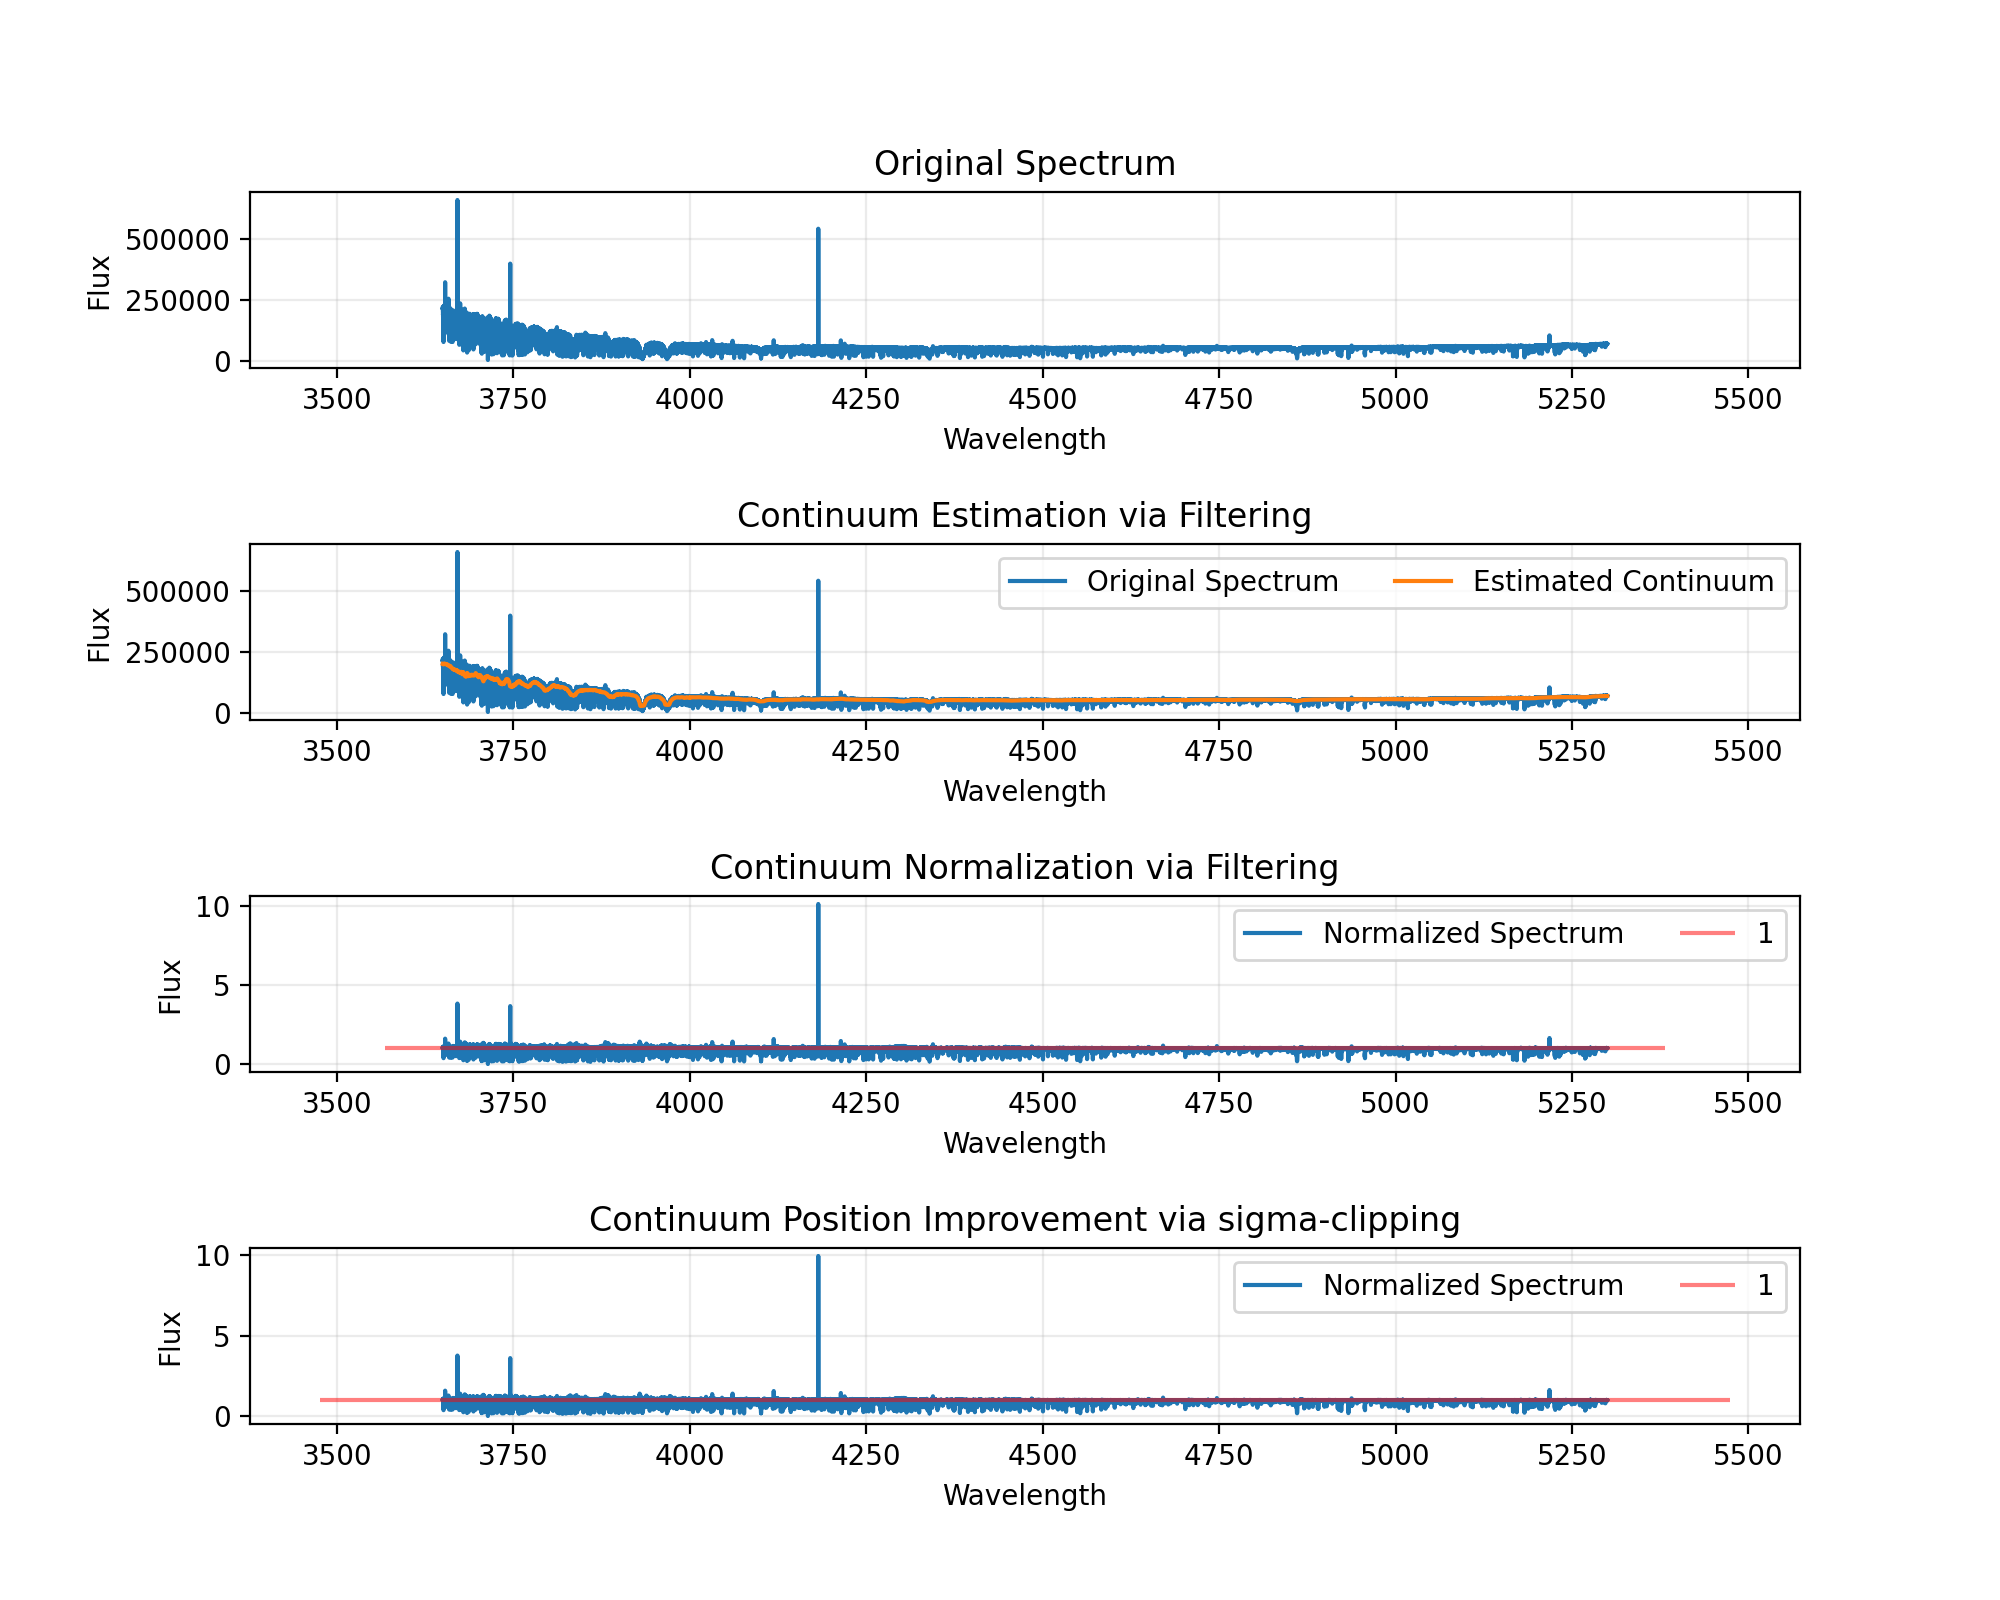

In [5]:
plt.figure(figsize=(10,8))

ax = plt.subplot( 411 )
plt.title('Original Spectrum')
plt.plot( wave, flux )
plt.grid(alpha=0.25)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

#-------------------
norm, cont = sa.contnorm_filter(flux, smooth_kernel, mode='reflect')

ax2 = plt.subplot( 412, sharex=ax )
plt.title('Continuum Estimation via Filtering')

plt.plot( wave, flux, label='Original Spectrum')
plt.plot( wave, cont, label='Estimated Continuum')
plt.grid(alpha=0.25)
plt.legend(ncol=2)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

ax3 = plt.subplot( 413, sharex=ax )
plt.title('Continuum Normalization via Filtering')
plt.plot( wave, norm, label='Normalized Spectrum')
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax,color='red',zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend(ncol=2)

#-------------------
norm2 = sa.contnorm_sigclip(norm, sigma_lower, sigma_upper)

ax4 = plt.subplot( 414, sharex=ax )
plt.title('Continuum Position Improvement via sigma-clipping')

plt.plot( wave, norm2, label='Normalized Spectrum')
plt.grid(alpha=0.25)
xmin, xmax = ax.get_xlim()
plt.hlines(1,xmin,xmax,color='red',zorder=5,alpha=0.5, label='1')
plt.xlabel('Wavelength')
plt.ylabel('Flux')

plt.legend(ncol=2)
plt.subplots_adjust(hspace=1)

*Optional: Save The Result*
```python
sa.write2bin(wave,norm,err, save_path )
```
OR 
```python
sa.write2xy(wave,norm, save_path )
```

# Method: User specified continuum curve

The above routine seems to work well for many spectra, but sometimes it does not.  The filtering for estimation of the continuum does not work very well for finding the continuum when there are very deep and wide spectral features. 

In this case the user can specify the position of the continuum using an interactive plot

In [6]:
# ------ Read in the spectrum
hdul = fits.open('../Data/GHOST_HD222925/HD222925_hr_1x1_b600r200_s1_20220628_1x1_blue1_formattedOutput.fits')
f = hdul[5].data.flatten()
w = hdul[7].data
e = hdul[6].data.flatten()


# Crop off noisey ends
w_min = 3650
w_max = 5300

ind = np.where( (w >= w_min) & (w <= w_max ) )[0]

w = w[ind]
f = np.array(f[ind].flatten(), dtype='float32')
e = np.array(e[ind].flatten(), dtype='float32')

<IPython.core.display.Javascript object>


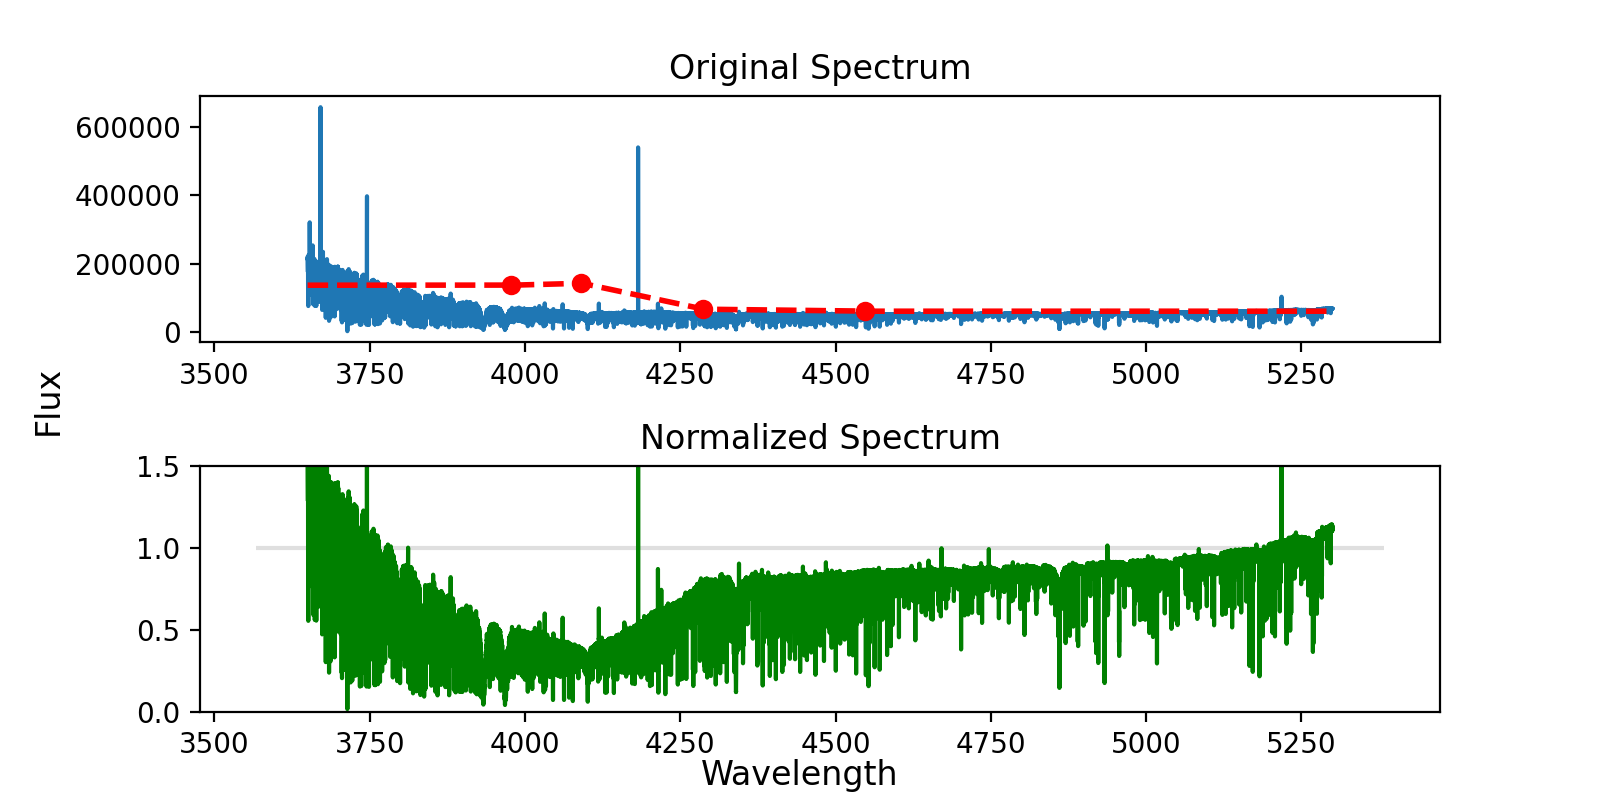

In [11]:
# ---------- Initialize and create continuum
continuum = sa.drawContinuum(w, f)
continuum.connect()

In [8]:
continuum.disconnect()

*Optional: Save The Result*
```python
sa.write2bin(wave,continuum.norm,err, save_path )
```
OR 
```python
sa.write2xy(wave,continuum.norm, save_path )
```

In [9]:
save_path = '../Data/GHOST_HD222925/HD222925Blue'

In [10]:
# sa.write2xy(w,continuum.norm,e, save_path )